# Classification mnist

This is an example to show how you can use MapReader on non-patchified datasets.

# Load
https://mapreader.readthedocs.io/en/latest/User-guide/Load.html

## Load images

We will load our mnist images as patches so MapReader knows we are going to be using these as our unit of analysis.

In [1]:
from mapreader import load_patches

path2images = "./small_mnist/*.png"
my_files = load_patches(path2images)

0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [2]:
# len() shows the total number of images currently read (or sliced, see below)
print(f"Number of images: {len(my_files)}")

Number of images: 200


In [3]:
print(my_files)

#images: 200

#parents: 0

#patches: 200
49081.png
51816.png
39566.png
24251.png
20989.png
29013.png
10692.png
58832.png
30556.png
10686.png
9294.png
...



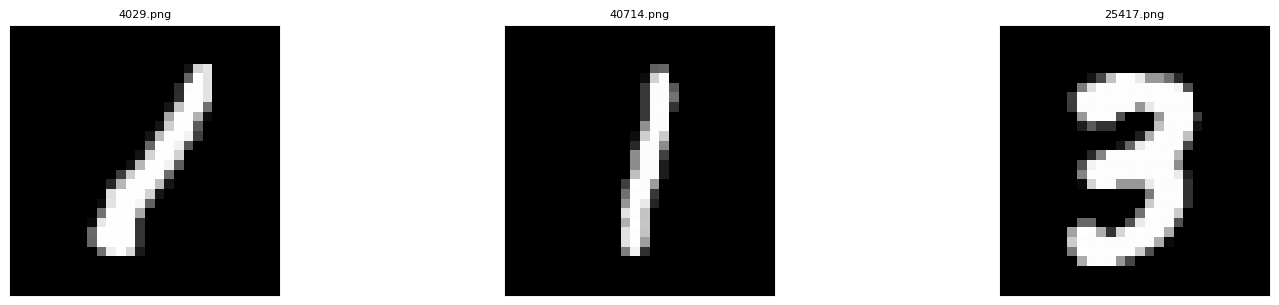

In [4]:
my_files.show_sample(num_samples=3, tree_level="patch")

In [5]:
my_files.add_shape(tree_level="patch")

[INFO] Add shape, tree level: patch


In [6]:
parent_df, patch_df = my_files.convert_images()

In [7]:
patch_df["pixel_bounds"] = patch_df["shape"].apply(lambda x: (0, 0, x[1], x[0]))
patch_df.head()

,parent_id,image_path,pixel_bounds,shape
image_id,,,,
49081.png,None,/Users/rwood/LwM/mapreader/MapReader/worked_ex...,"(0, 0, 28, 28)","(28, 28, 1)"
51816.png,None,/Users/rwood/LwM/mapreader/MapReader/worked_ex...,"(0, 0, 28, 28)","(28, 28, 1)"
39566.png,None,/Users/rwood/LwM/mapreader/MapReader/worked_ex...,"(0, 0, 28, 28)","(28, 28, 1)"
24251.png,None,/Users/rwood/LwM/mapreader/MapReader/worked_ex...,"(0, 0, 28, 28)","(28, 28, 1)"
20989.png,None,/Users/rwood/LwM/mapreader/MapReader/worked_ex...,"(0, 0, 28, 28)","(28, 28, 1)"


# Annotate
https://mapreader.readthedocs.io/en/latest/User-guide/Annotate.html

In [8]:
from mapreader import Annotator

In [13]:
annotator = Annotator(
    patch_df=patch_df,
    parent_df=parent_df,
    labels=["1", "3"],
    annotations_dir="./annotations_mnist",
    username="kasra",
    task_name="mnist",
    show_context=False,
)

In [16]:
annotator.annotate(resize_to=400)

Output(layout=Layout(align_items='center', display='flex', flex_flow='column'))

# Classify - Train

https://mapreader.readthedocs.io/en/latest/User-guide/Classify.html

## Read annotations

In [9]:
from mapreader import AnnotationsLoader

In [10]:
annotated_images = AnnotationsLoader()

annotated_images.load("./annotations_mnist/mnist_#kasra#.csv", images_dir="./small_mnist/")

[INFO] Reading "./annotations_mnist/mnist_#kasra#.csv"
[INFO] Number of annotations:   164

[INFO] Number of instances of each label (from column "label"):
    - 2:  87
    - 1:  77



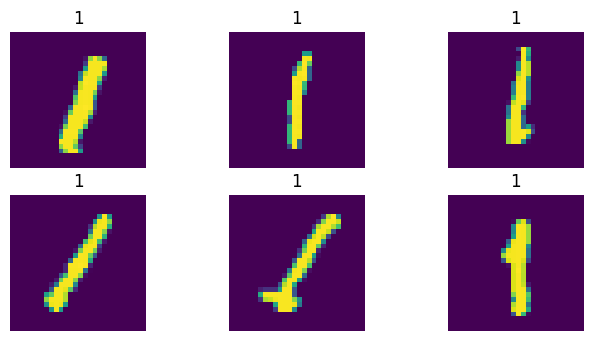

In [11]:
# show sample images for one label (label_to_show)
annotated_images.show_sample(label_to_show="1", num_samples=6)

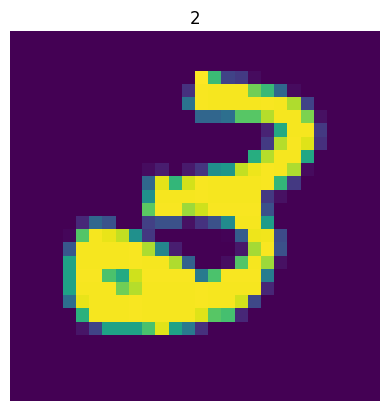

In [12]:
# show an image based on its index
annotated_images.show_patch(patch_id="20989.png")

## Prepare datasets and dataloaders

In [13]:
annotated_images.create_datasets(frac_train=0.7, frac_val=0.2, frac_test=0.1)

[INFO] Number of annotations in each set:
    - train:   114
    - val:   33
    - test:   17


In [14]:
dataloaders = annotated_images.create_dataloaders(batch_size=8, sampler="default")

[INFO] Using default sampler.


## Set up `ClassifierContainer`

### Load a (pretrained) PyTorch model and combine with dataloaders

In [15]:
from mapreader import ClassifierContainer

In [16]:
my_classifier = ClassifierContainer(model="resnet18", 
                                    labels_map={0: "3", 1: "1"},
                                    dataloaders=dataloaders
                                    )

[INFO] Device is set to cpu
[INFO] Initializing model.
[INFO] Loaded "train" with 114 items.
[INFO] Loaded "val" with 33 items.
[INFO] Loaded "test" with 17 items.


In [17]:
my_classifier.model_summary()

Layer (type:depth-idx)                   Output Shape              Output Shape              Param #
ResNet                                   [8, 2]                    [8, 2]                    --
├─Conv2d: 1-1                            [8, 64, 112, 112]         [8, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [8, 64, 112, 112]         [8, 64, 112, 112]         128
├─ReLU: 1-3                              [8, 64, 112, 112]         [8, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [8, 64, 56, 56]           [8, 64, 56, 56]           --
├─Sequential: 1-5                        [8, 64, 56, 56]           [8, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [8, 64, 56, 56]           [8, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [8, 64, 56, 56]           [8, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [8, 64, 56, 56]           [8, 64, 56, 56]           128
│    │    └─ReLU: 3-3     

### Set up loss function, optimizer and scheduler

In [ ]:
my_classifier.add_loss_fn("cross-entropy")

In [19]:
params_to_optimize = my_classifier.generate_layerwise_lrs(
    min_lr=1e-4, max_lr=1e-3, spacing="geomspace"
)

In [20]:
my_classifier.initialize_optimizer(params2optimize=params_to_optimize)

In [21]:
my_classifier.initialize_scheduler()

## Train/fine-tune a model

In [22]:
my_classifier.train(
    num_epochs=15,
    save_model_dir="./models_mnist",
    tensorboard_path="tboard_mnist",
    tmp_file_save_freq=2,
    remove_after_load=False,
    print_info_batch_freq=5,
)

[INFO] Each step will pass: ['train', 'val'].
2024-05-13 08:58:54 599-JY5FK6 [INFO] train    -- 1/15 --      8/114 (  7.0% ) -- Loss: 1.051
2024-05-13 08:58:58 599-JY5FK6 [INFO] train    -- 1/15 --     48/114 ( 42.1% ) -- Loss: 0.000
2024-05-13 08:59:00 599-JY5FK6 [INFO] train    -- 1/15 --     88/114 ( 77.2% ) -- Loss: 0.016
2024-05-13 08:59:02 599-JY5FK6 [INFO] train    -- 1/15 -- Loss: 0.330; F_macro: 86.82; R_macro: 86.85
2024-05-13 08:59:02 599-JY5FK6 [INFO] val      -- 1/15 --       8/33 ( 24.2% ) -- Loss: 1.457
2024-05-13 08:59:03 599-JY5FK6 [INFO] val      -- 1/15 -- Loss: 1.388; F_macro: 59.35; R_macro: 63.33

2024-05-13 08:59:04 599-JY5FK6 [INFO] train    -- 2/15 --      8/114 (  7.0% ) -- Loss: 0.003
2024-05-13 08:59:06 599-JY5FK6 [INFO] train    -- 2/15 --     48/114 ( 42.1% ) -- Loss: 0.014
2024-05-13 08:59:08 599-JY5FK6 [INFO] train    -- 2/15 --     88/114 ( 77.2% ) -- Loss: 0.014
2024-05-13 08:59:10 599-JY5FK6 [INFO] train    -- 2/15 -- Loss: 0.103; F_macro: 97.33; R_ma

In [23]:
list(my_classifier.metrics.keys())

['epoch_loss_train',
 'epoch_prec_micro_train',
 'epoch_recall_micro_train',
 'epoch_fscore_micro_train',
 'epoch_supp_micro_train',
 'epoch_rocauc_micro_train',
 'epoch_prec_macro_train',
 'epoch_recall_macro_train',
 'epoch_fscore_macro_train',
 'epoch_supp_macro_train',
 'epoch_rocauc_macro_train',
 'epoch_prec_weighted_train',
 'epoch_recall_weighted_train',
 'epoch_fscore_weighted_train',
 'epoch_supp_weighted_train',
 'epoch_rocauc_weighted_train',
 'epoch_prec_0_train',
 'epoch_recall_0_train',
 'epoch_fscore_0_train',
 'epoch_supp_0_train',
 'epoch_prec_1_train',
 'epoch_recall_1_train',
 'epoch_fscore_1_train',
 'epoch_supp_1_train',
 'epoch_loss_val',
 'epoch_prec_micro_val',
 'epoch_recall_micro_val',
 'epoch_fscore_micro_val',
 'epoch_supp_micro_val',
 'epoch_rocauc_micro_val',
 'epoch_prec_macro_val',
 'epoch_recall_macro_val',
 'epoch_fscore_macro_val',
 'epoch_supp_macro_val',
 'epoch_rocauc_macro_val',
 'epoch_prec_weighted_val',
 'epoch_recall_weighted_val',
 'epoch_fs

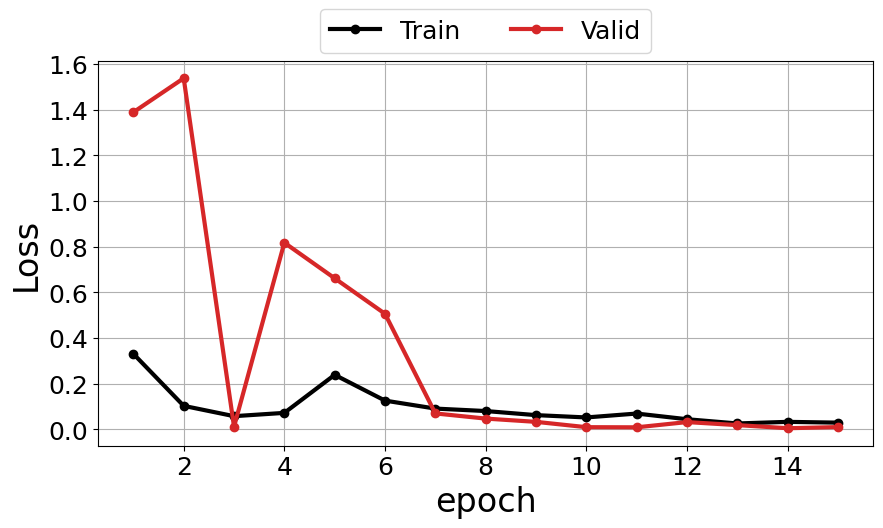

In [24]:
my_classifier.plot_metric(
    y_axis=["epoch_loss_train", "epoch_loss_val"],
    y_label="Loss",
    legends=["Train", "Valid"],
    colors=["k", "tab:red"],
)

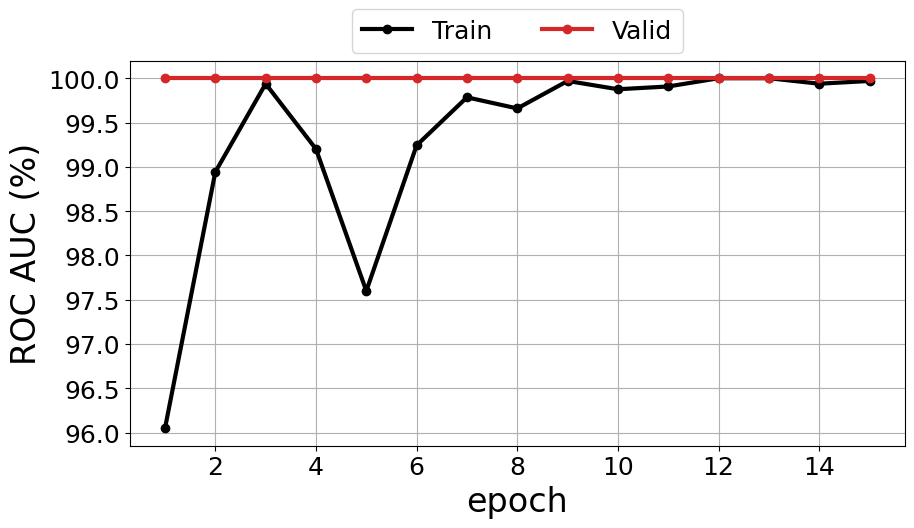

In [25]:
my_classifier.plot_metric(
    y_axis=["epoch_rocauc_macro_train", "epoch_rocauc_macro_val"],
    y_label="ROC AUC (%)",
    legends=["Train", "Valid"],
    colors=["k", "tab:red"],
)

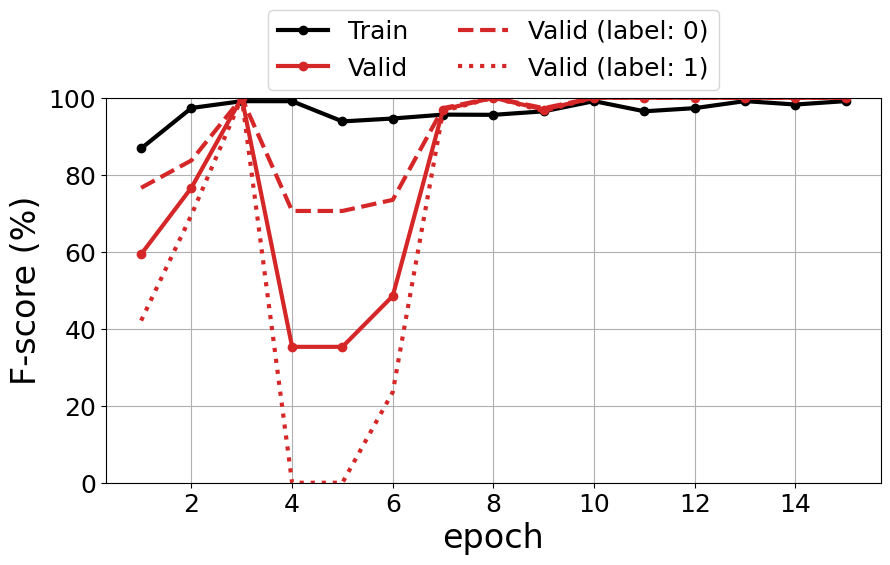

In [26]:
my_classifier.plot_metric(
    y_axis=[
        "epoch_fscore_macro_train",
        "epoch_fscore_macro_val",
        "epoch_fscore_0_val",
        "epoch_fscore_1_val",
    ],
    y_label="F-score (%)",
    legends=[
        "Train",
        "Valid",
        "Valid (label: 0)",
        "Valid (label: 1)",
    ],
    colors=["k", "tab:red", "tab:red", "tab:red"],
    styles=["-", "-", "--", ":"],
    markers=["o", "o", "", ""],
    plt_yrange=[0, 100],
)

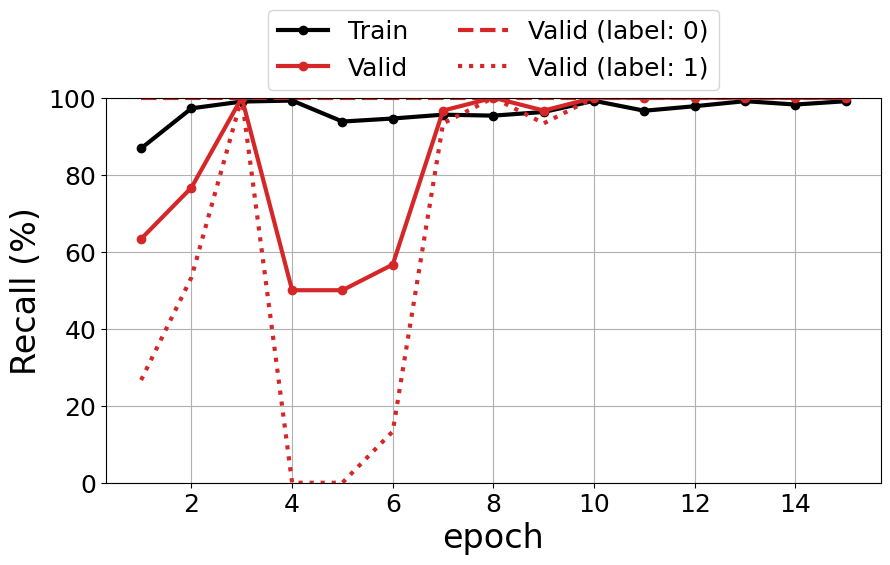

In [27]:
my_classifier.plot_metric(
    y_axis=[
        "epoch_recall_macro_train",
        "epoch_recall_macro_val",
        "epoch_recall_0_val",
        "epoch_recall_1_val",
    ],
    y_label="Recall (%)",
    legends=[
        "Train",
        "Valid",
        "Valid (label: 0)",
        "Valid (label: 1)",
    ],
    colors=["k", "tab:red", "tab:red", "tab:red"],
    styles=["-", "-", "--", ":"],
    markers=["o", "o", "", ""],
    plt_yrange=[0, 100],
)

# Classify - Infer

https://mapreader.readthedocs.io/en/latest/User-guide/Classify.html

## Create dataset with all mnist data and add to ``ClassifierContainer``

In [30]:
from mapreader import PatchDataset

In [31]:
data = PatchDataset(patch_df, transform="val")

In [32]:
my_classifier.load_dataset(data, set_name="all_mnist")

## Infer labels

In [33]:
my_classifier.inference("all_mnist")

[INFO] Each step will pass: ['all_mnist'].
2024-02-22 09:56:58 599-JY5FK6 [INFO] all_mnist -- 16/16 --     16/200 (  8.0% ) -- 
2024-02-22 09:57:02 599-JY5FK6 [INFO] all_mnist -- 16/16 --     96/200 ( 48.0% ) -- 
2024-02-22 09:57:07 599-JY5FK6 [INFO] all_mnist -- 16/16 --    176/200 ( 88.0% ) -- 
[INFO] Total time: 0m 11s


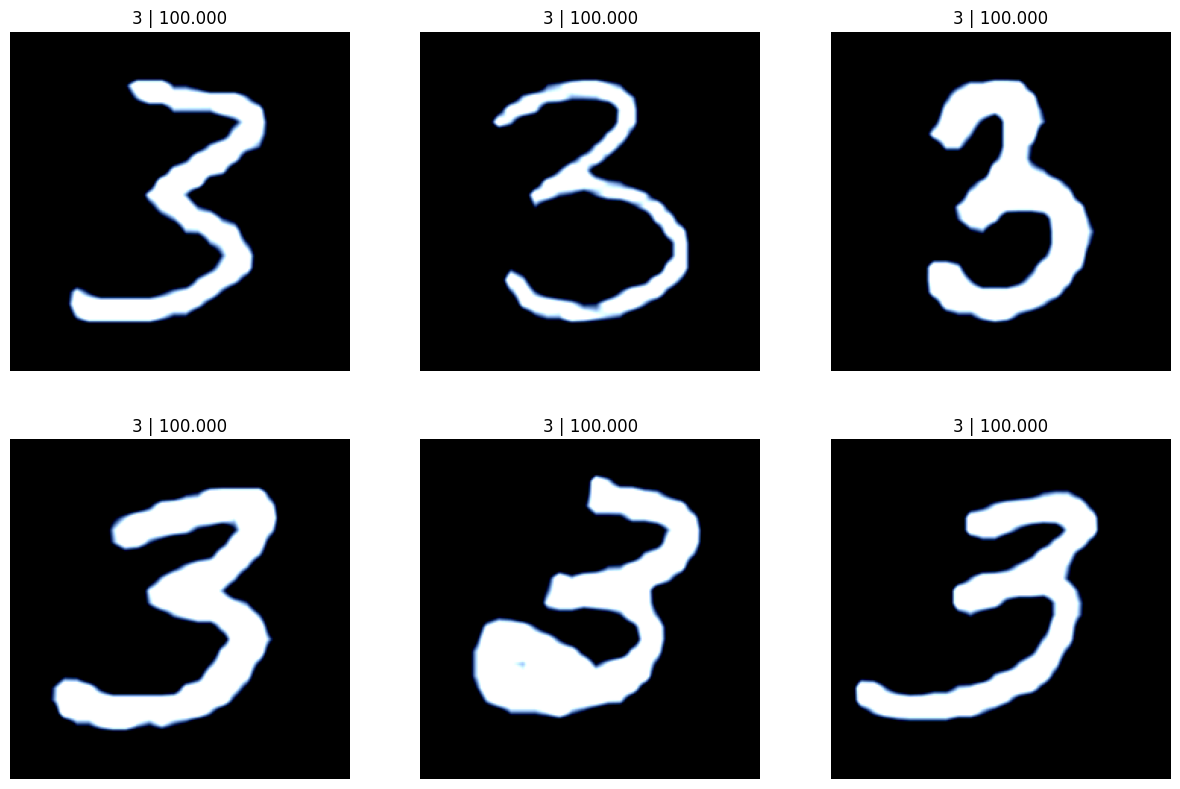

In [34]:
my_classifier.show_inference_sample_results(
    label="3", set_name="all_mnist", min_conf=99
)